# dots measurement at Subaru (20211014 on-telecope) (for only 1 visit to check)

In [5]:
%matplotlib notebook

import pandas as pd
import sep
import cv2
from copy import deepcopy

import os
import sys
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import ndimage as nd

In [6]:
data_dir = '/work/PFS/pfi/data/erun03/2021-09-26'
repo_dir = '/work/PFS/repo/pfs_instdata'
ff_data_dir = '/work/PFS/pfi/data/ffdata'

## rotator angle = 0 deg., EL = 90 deg.

### designed dots infomation

In [7]:
filename = os.path.join(repo_dir, 'data/pfi/dot',
                        'dot_design_asrd_20210422.txt')
fel = pd.read_csv(filename,
                  delim_whitespace=True,
                  header=None,
                  names=['id', 'x_mm', 'y_mm', 'x', 'y', 'bb', 'cc']
                 )
fel[:3]

,id,x_mm,y_mm,x,y,bb,cc
0,0,96.994843,0.0,5614.759176,2886.225955,5614.759277,2886.101562
1,1,103.923042,4.0,5695.685201,2932.765529,5695.393555,2932.880127
2,2,110.851250,8.0,5776.593112,2979.286068,5776.393066,2979.337891


### observed data

In [9]:
visit = 68840
filename = os.path.join(data_dir, 'PFSC%06d00.fits' % (visit))
with pyfits.open(filename) as f:
    data = f[1].data

### median filtering

In [10]:
data_med = nd.median_filter(data, size=3)

### transformation for initial guess (you need to do this carefully)

In [11]:
filename = 'black_dots_mcs_pix_rough_position_20211108.csv'
dots_mcs_rough = pd.read_csv(filename)
dots_mcs_rough[:3]

,dotId,x,y,r
0,0,4490.5220,2786.7947,8.9
1,1,4443.3780,2704.5344,8.9
2,2,4396.2334,2622.2979,8.9


In [15]:
rx = dots_mcs_rough['x']
ry = dots_mcs_rough['y']

### data region trimming

<IPython.core.display.Javascript object>


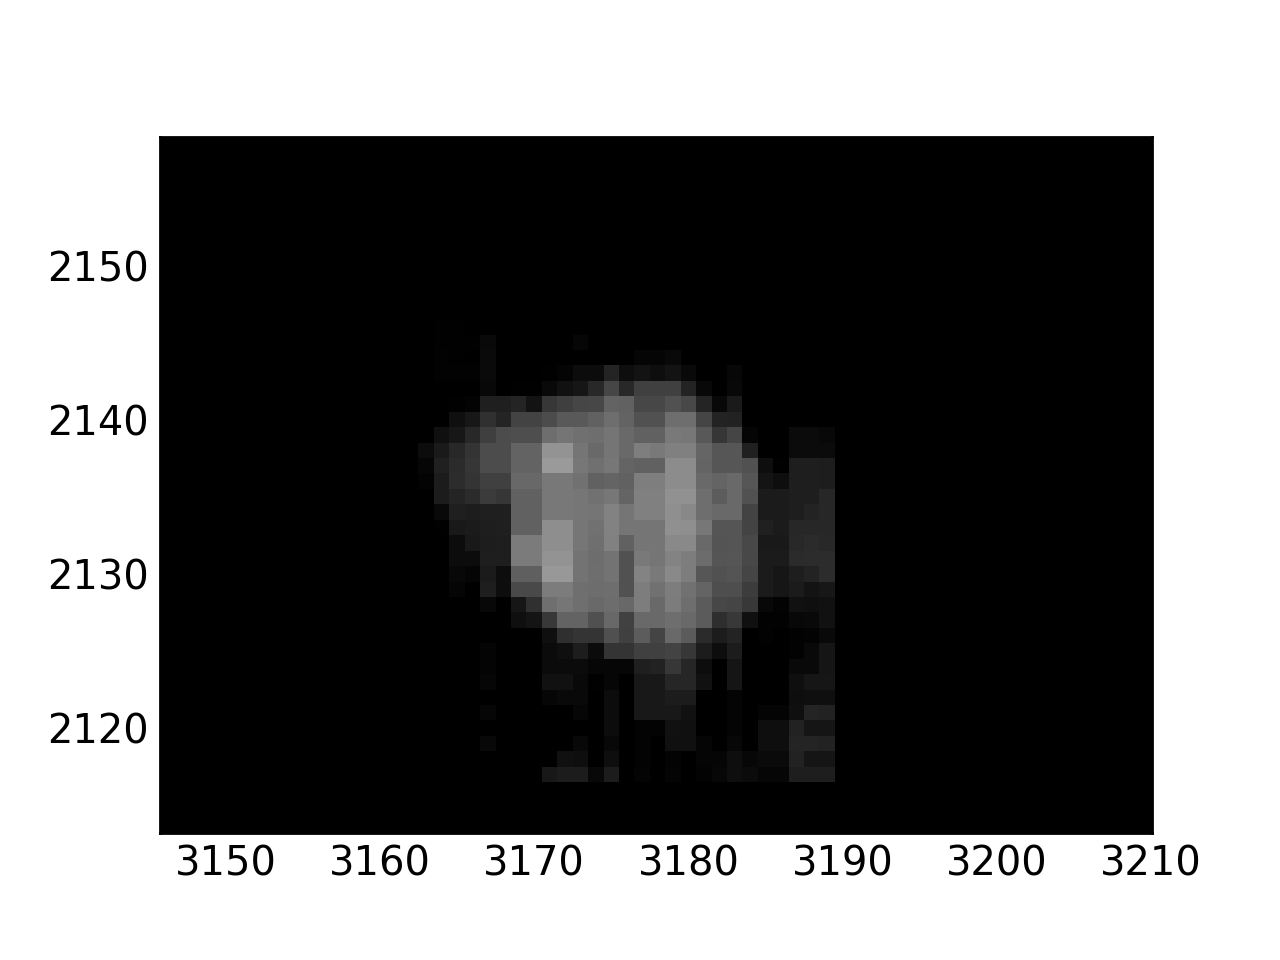

In [16]:
reg=15
thresh=3000

v_med =  np.median(data_med)
imag_new = np.zeros(data_med.shape)
#imag_new = np.zeros(data.shape)

for xd, yd in zip(rx, ry):
    x1 = int(xd - reg)
    x2 = int(xd + reg)
    y1 = int(yd - reg)
    y2 = int(yd + reg)
    v_med = np.median(data_med[y1-reg:y2+reg, x1-reg:x2+reg])
    imag_new[y1:y2, x1:x2] = data_med[y1:y2, x1:x2] - v_med
    
#imag_new[imag_new > thresh] = v_med

#plt.imshow(imag_new, origin='lower', cmap='gray', vmin=38000, vmax=40000)
plt.imshow(imag_new, origin='lower', cmap='gray', vmin=0, vmax=500)

### measure dot positions

In [17]:
reg=15

bad_idx = []
dot_pos = []
for i in range(len(rx)):
    #data_sub=imag_new_flt[int(ry[i]-reg):int(ry[i]+reg),int(rx[i]-reg):int(rx[i]+reg)]
    data_sub=imag_new[int(ry[i]-reg):int(ry[i]+reg),int(rx[i]-reg):int(rx[i]+reg)]
    imag_sub=deepcopy(data_sub)
    imag_sub[imag_sub<=0]=0.0
    imag_sub = 255 * imag_sub / imag_sub.max()

    circles = cv2.HoughCircles(imag_sub.astype('uint8'), cv2.HOUGH_GRADIENT, 1, 50,
                               param1=100,param2=3,minRadius=7,maxRadius=10)

    if circles is not None:
        dot_x = int(rx[i]-reg)+circles[0,0,0]
        dot_y = int(ry[i]-reg)+circles[0,0,1]
        dot_r = circles[0,0,2]
        dot_pos.append((dot_x, dot_y, dot_r))
    else:
        bad_idx.append(i)
        dot_pos.append((np.nan, np.nan, np.nan))
        print(f' dota id {i} at {rx[i]} {ry[i]} detection failed')
        
dot_pos = np.array(dot_pos)

<IPython.core.display.Javascript object>


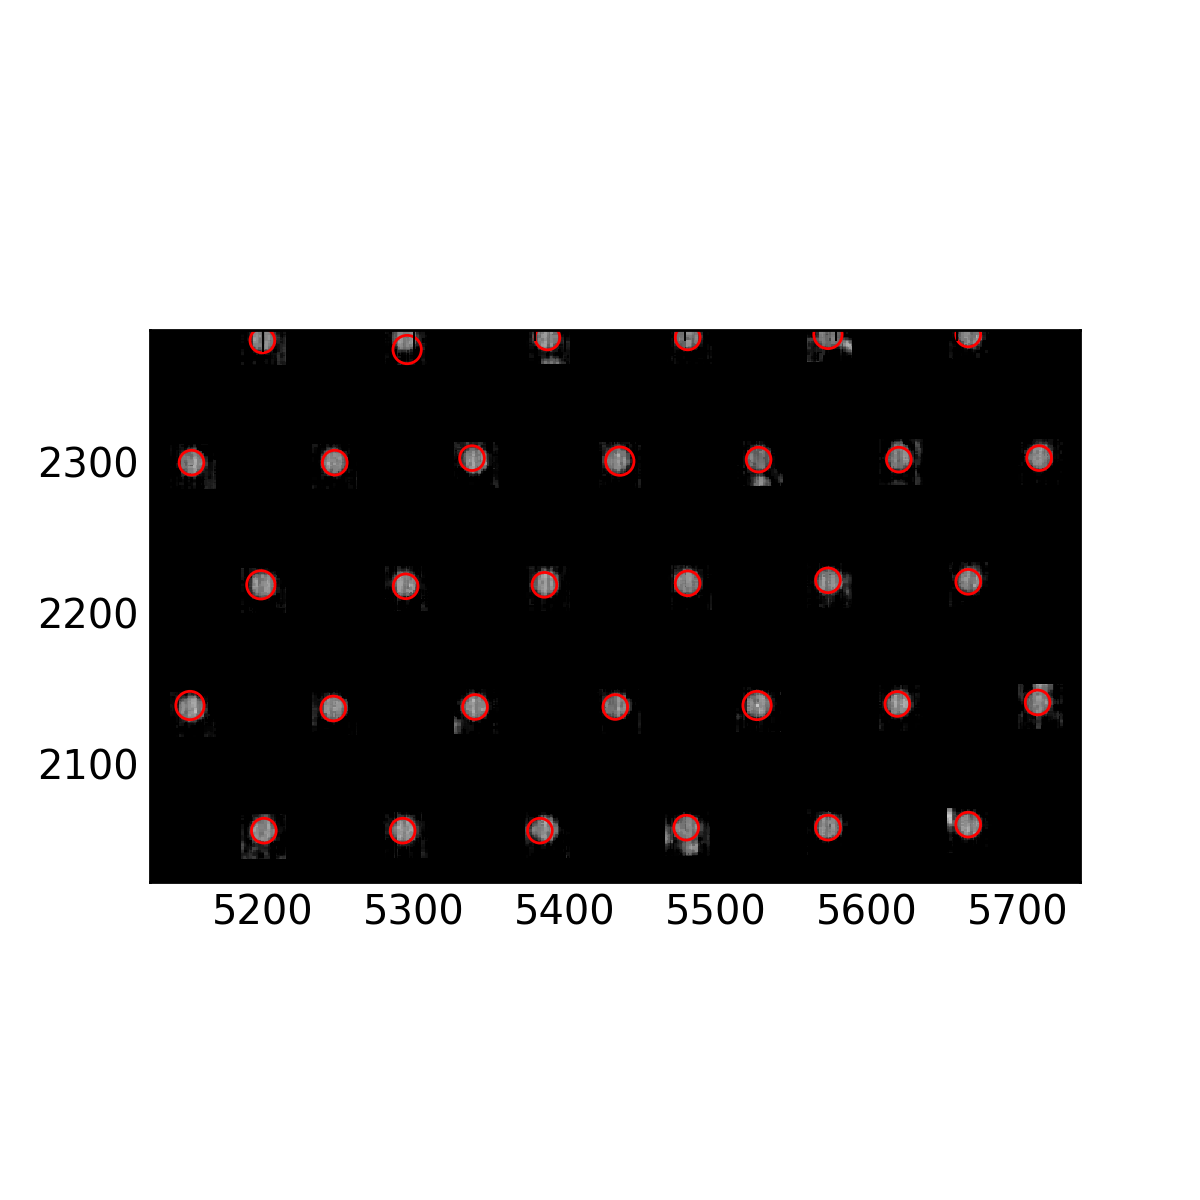

In [18]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')
im = ax.imshow(imag_new, interpolation='nearest', cmap='gray', vmin=0, vmax=500, origin='lower')

for p in dot_pos:
    c = plt.Circle((p[0], p[1]), p[2], color='red', fill=False)
    ax.add_artist(c)
    
plt.show()

### get transformation coefficients (including distortion)

In [19]:
pts0=np.zeros((1,len(fel),3))
pts0[0,:,0]=fel['x_mm']
pts0[0,:,1]=fel['y_mm']
pts0[0,:,2]=[0 for x in fel['x_mm']]
pts1=np.zeros((1,len(fel),3))
pts2=np.zeros((1,len(fel),2))
pts1[0,:,0]=fel['x_mm']
pts1[0,:,1]=fel['y_mm']
pts1[0,:,2]=[0 for x in fel['x_mm']]
pts2[0,:,0]=dot_pos[:,0]
pts2[0,:,1]=dot_pos[:,1]

pts1 = np.float32(pts1)
pts2 = np.float32(pts2)

In [20]:
for i in np.sort(bad_idx)[::-1]:
    pts1 = np.delete(pts1, i, 1)
    pts2 = np.delete(pts2, i, 1)    

In [21]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(pts1, pts2, data.shape[::-1], None, None)

In [22]:
for i in range(len(pts0)):
    imgpoints2, _ = cv2.projectPoints(pts0[i].astype(np.float32),rvecs[i], tvecs[i], mtx, dist)

In [23]:
dot_pos_new = np.float32([[x,y,r] for x,y,r in zip(imgpoints2[:,0,0], imgpoints2[:,0,1], dot_pos[:,2])])

<IPython.core.display.Javascript object>


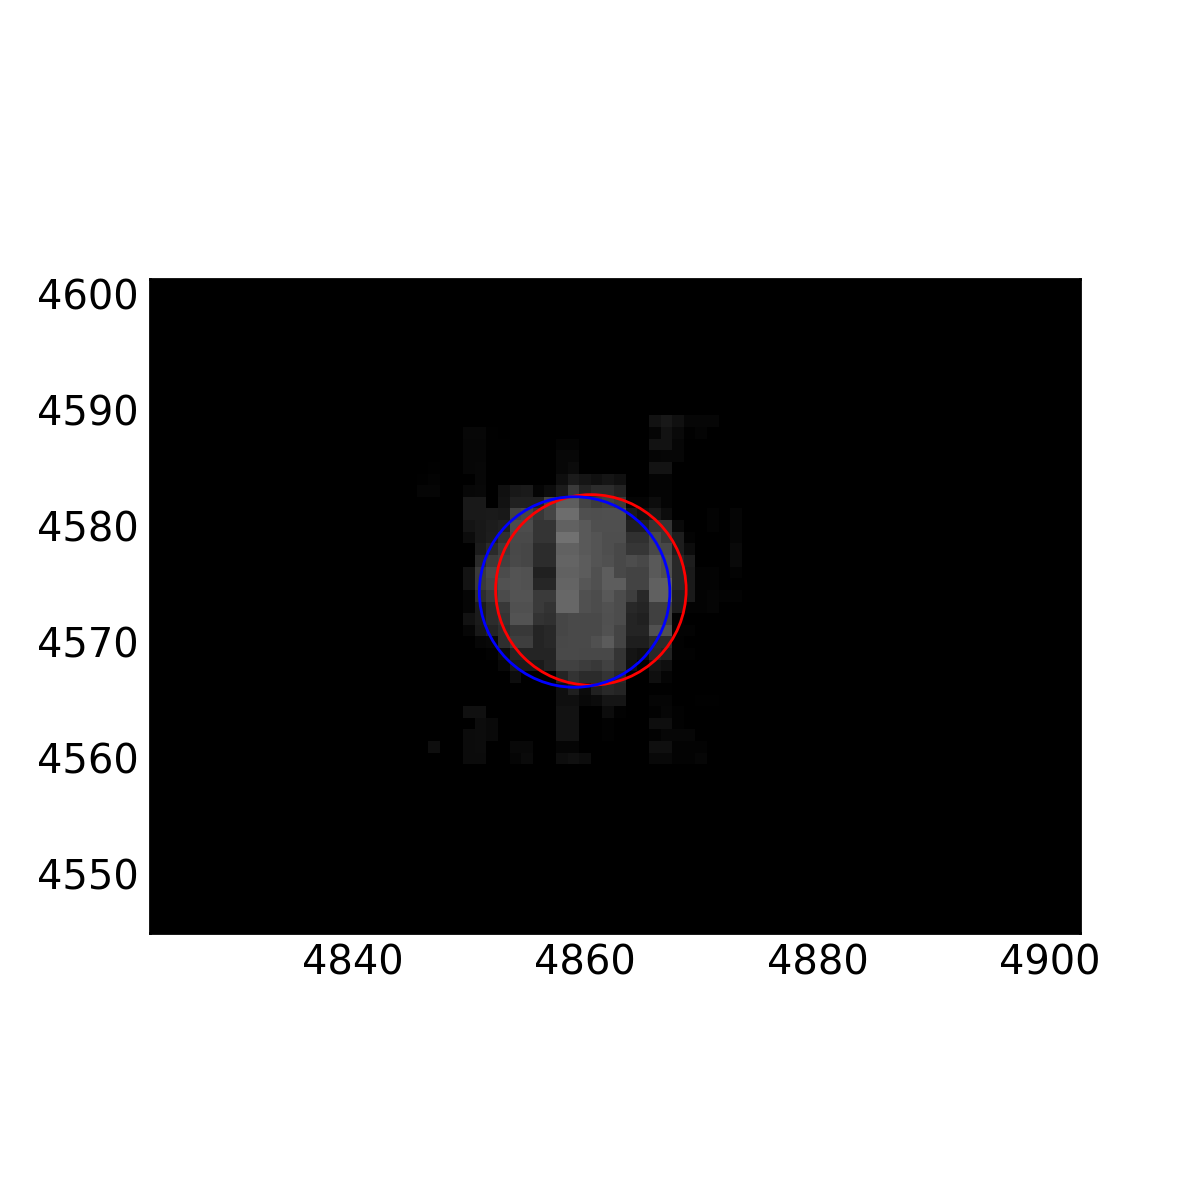

In [24]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')

im = ax.imshow(imag_new, interpolation='nearest', cmap='gray', vmin=0, vmax=500, origin='lower')

for p in dot_pos:
    c = plt.Circle((p[0], p[1]), p[2], color='red', fill=False)
    ax.add_artist(c)
for p in dot_pos_new:
    c = plt.Circle((p[0], p[1]), p[2], color='blue', fill=False)
    ax.add_artist(c)
    
plt.show()

### data region triming (2nd pass)

In [25]:
rx2 = dot_pos_new[:,0]
ry2 = dot_pos_new[:,1]

<IPython.core.display.Javascript object>


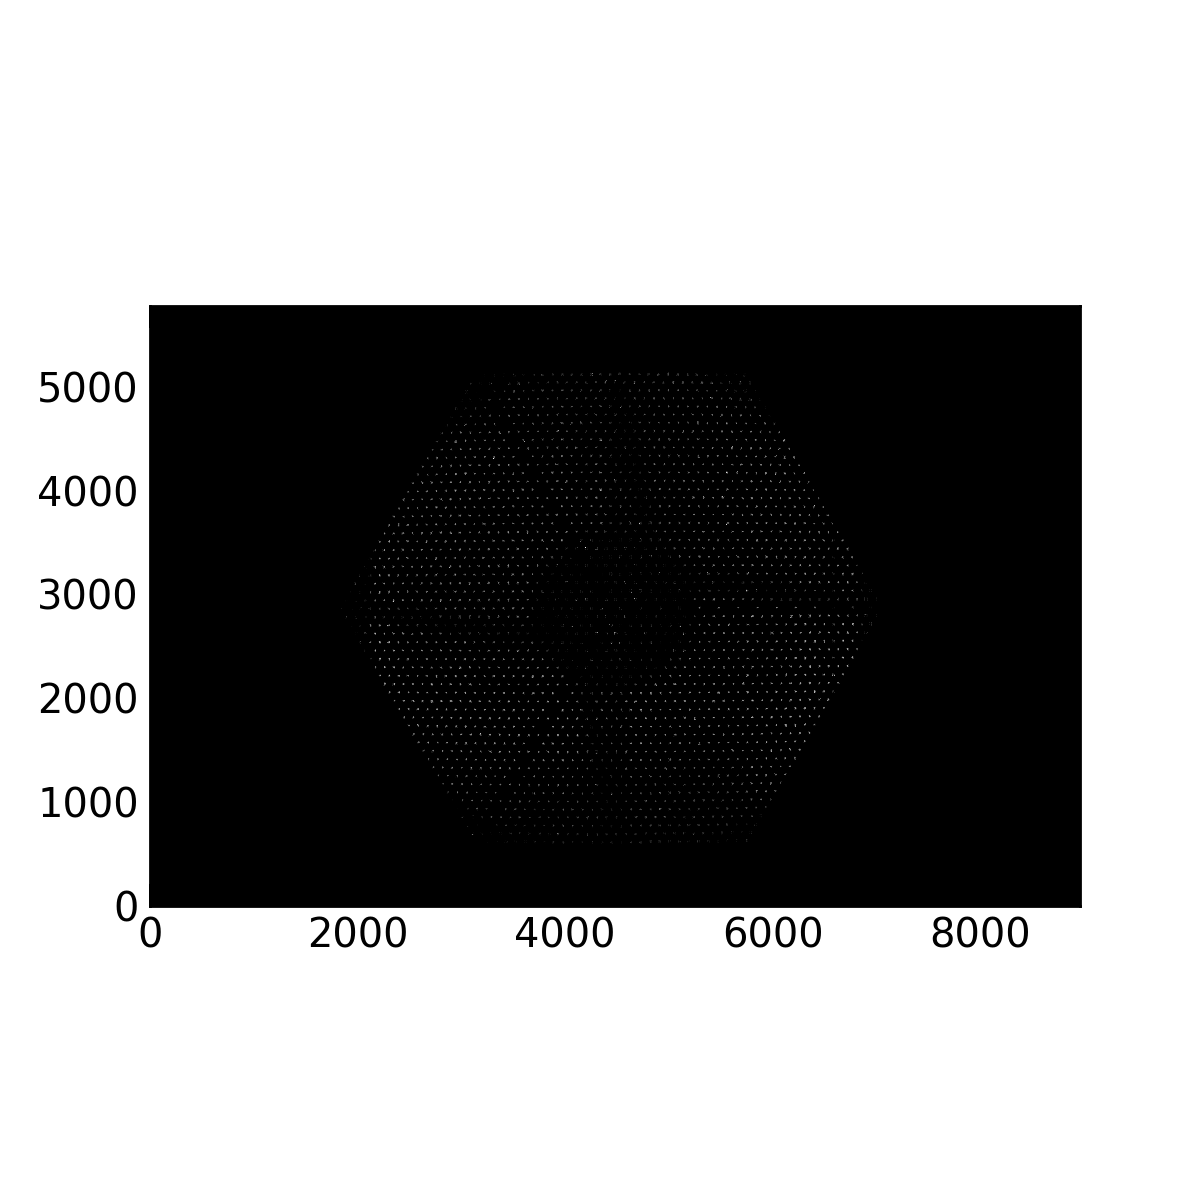

In [26]:
reg=15
thresh=3000

v_med =  np.median(data_med)
imag_new2 = np.zeros(data_med.shape)

for xd, yd in zip(rx2, ry2):
    x1 = int(xd - reg)
    x2 = int(xd + reg)
    y1 = int(yd - reg)
    y2 = int(yd + reg)
    v_med = np.median(data_med[y1-reg:y2+reg, x1-reg:x2+reg])
    imag_new2[y1:y2, x1:x2] = data_med[y1:y2, x1:x2] - v_med
    

fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')

im = ax.imshow(imag_new2, interpolation='nearest', cmap='gray', vmin=0, vmax=500, origin='lower')

plt.show()

### measure dot positions (2nd pass)

In [27]:
reg=15

imag_new2_disp = deepcopy(imag_new2)

bad_idx = []
dot_pos2 = []
for i in range(len(rx2)):
    data_sub=imag_new2[int(ry2[i]-reg):int(ry2[i]+reg),int(rx2[i]-reg):int(rx2[i]+reg)]
    imag_sub=deepcopy(data_sub)
    #val_cnt = np.nanmedian(imag_sub[int(0.7*reg):int(1.3*reg), int(0.7*reg):int(1.3*reg)])
    #imag_sub[imag_sub>2.0*val_cnt] = 0.0
    #imag_sub[imag_sub<0.5*val_cnt] = 0.0
    imag_sub = 255 * imag_sub / imag_sub.max()

    imag_new2_disp[int(ry2[i]-reg):int(ry2[i]+reg),int(rx2[i]-reg):int(rx2[i]+reg)] = imag_sub
    
    circles = cv2.HoughCircles(imag_sub.astype('uint8'), cv2.HOUGH_GRADIENT, 1, 50,
                               param1=100,param2=5,minRadius=7,maxRadius=10)

    if circles is not None:
        dot_x = int(rx2[i]-reg) + circles[0,0,0]
        dot_y = int(ry2[i]-reg) + circles[0,0,1]
        dot_r = circles[0,0,2]
        dot_pos2.append((dot_x, dot_y, dot_r))
    else:
        bad_idx.append(i)
        dot_pos2.append((np.nan, np.nan, np.nan))
        print(f' dota id {i} at {rx[i]} {ry[i]} detection failed')

dot_pos2 = np.array(dot_pos2)

<IPython.core.display.Javascript object>


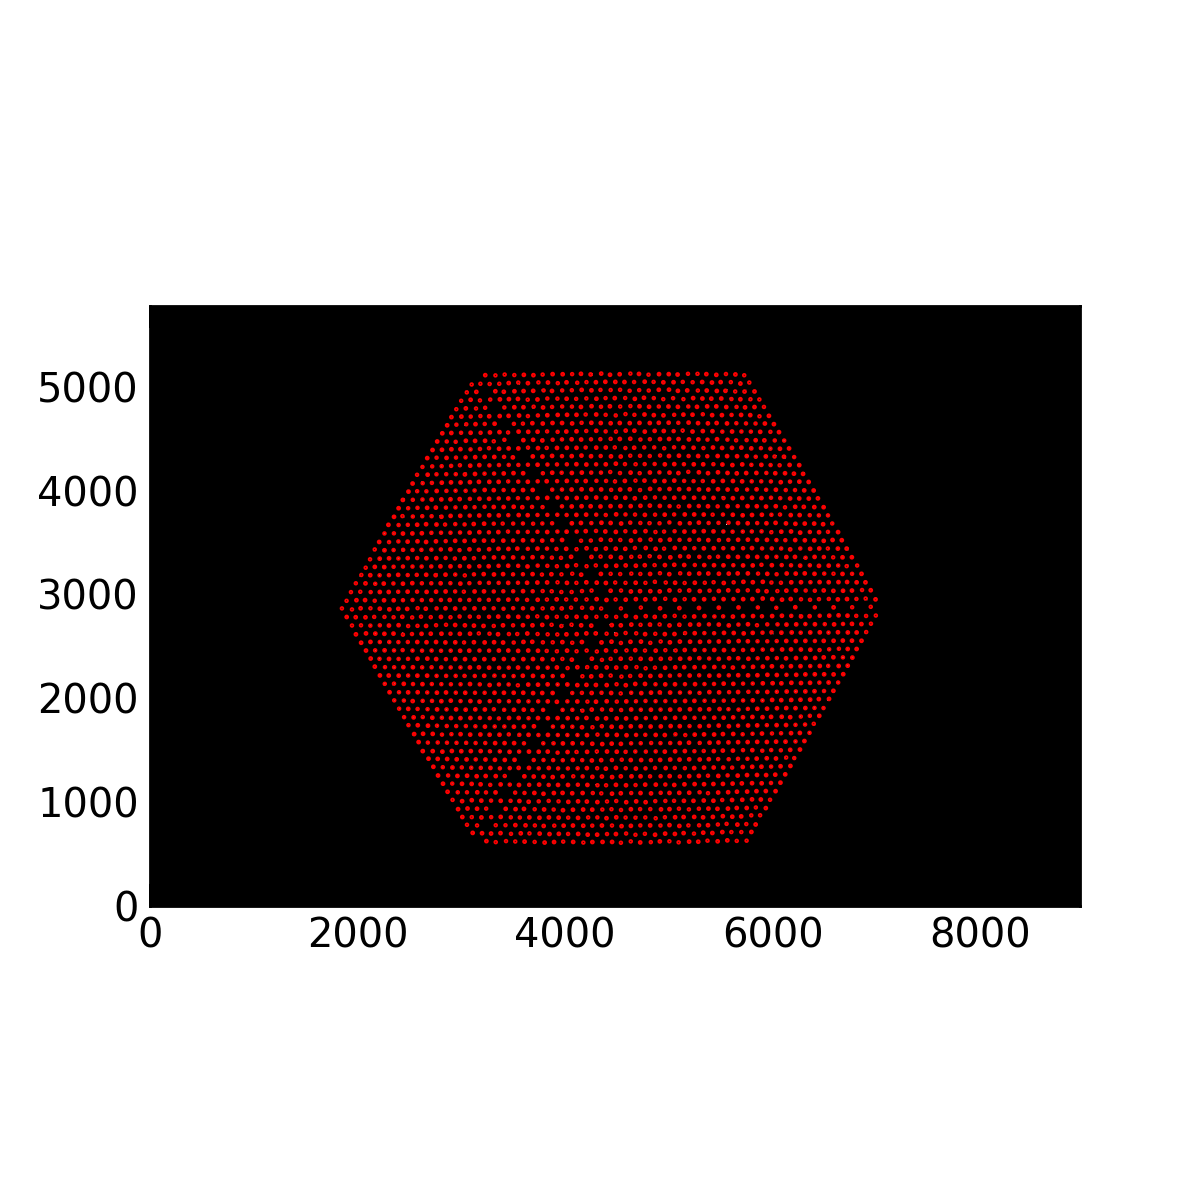

In [28]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')

im = ax.imshow(imag_new2, interpolation='nearest', cmap='gray', vmin=0, vmax=500, origin='lower')

for p in dot_pos2:
    c = plt.Circle((p[0], p[1]), p[2], color='red', fill=False)
    ax.add_artist(c)
    
plt.show()

### get transformation coefficients (2nd pass)

In [29]:
pts0=np.zeros((1,len(fel),3))
pts0[0,:,0]=fel['x_mm']
pts0[0,:,1]=fel['y_mm']
pts0[0,:,2]=[0 for x in fel['x_mm']]
pts1=np.zeros((1,len(fel),3))
pts2=np.zeros((1,len(fel),2))
pts1[0,:,0]=fel['x_mm']
pts1[0,:,1]=fel['y_mm']
pts1[0,:,2]=[0 for x in fel['x_mm']]
pts2[0,:,0]=dot_pos2[:,0]
pts2[0,:,1]=dot_pos2[:,1]

pts1 = np.float32(pts1)
pts2 = np.float32(pts2)

In [30]:
for i in bad_idx:
    pts1 = np.delete(pts1, i, 1)
    pts2 = np.delete(pts2, i, 1)    

In [31]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(pts1, pts2, data.shape[::-1], None, None)

In [32]:
## calculate dot position ##
for i in range(len(pts0)):
    imgpoints2, _ = cv2.projectPoints(pts0[i].astype(np.float32),rvecs[i], tvecs[i], mtx, dist)

In [33]:
## calculate dot radius ##
pts0d = deepcopy(pts0)
pts0d[0,:,0] = pts0d[0,:,0] + 1.5

for i in range(len(pts0)):
    tmp1, _ = cv2.projectPoints(pts0[i].astype(np.float32),rvecs[i], tvecs[i], mtx, dist)
for i in range(len(pts0d)):
    tmp2, _ = cv2.projectPoints(pts0d[i].astype(np.float32),rvecs[i], tvecs[i], mtx, dist)

dot_rad = (tmp1[:,0,1] - tmp2[:,0,1]) / 2.0

In [34]:
dot_pos_new2 = np.float32([[x,y,r] for x,y,r in zip(imgpoints2[:,0,0], imgpoints2[:,0,1], dot_rad[:])])

<IPython.core.display.Javascript object>


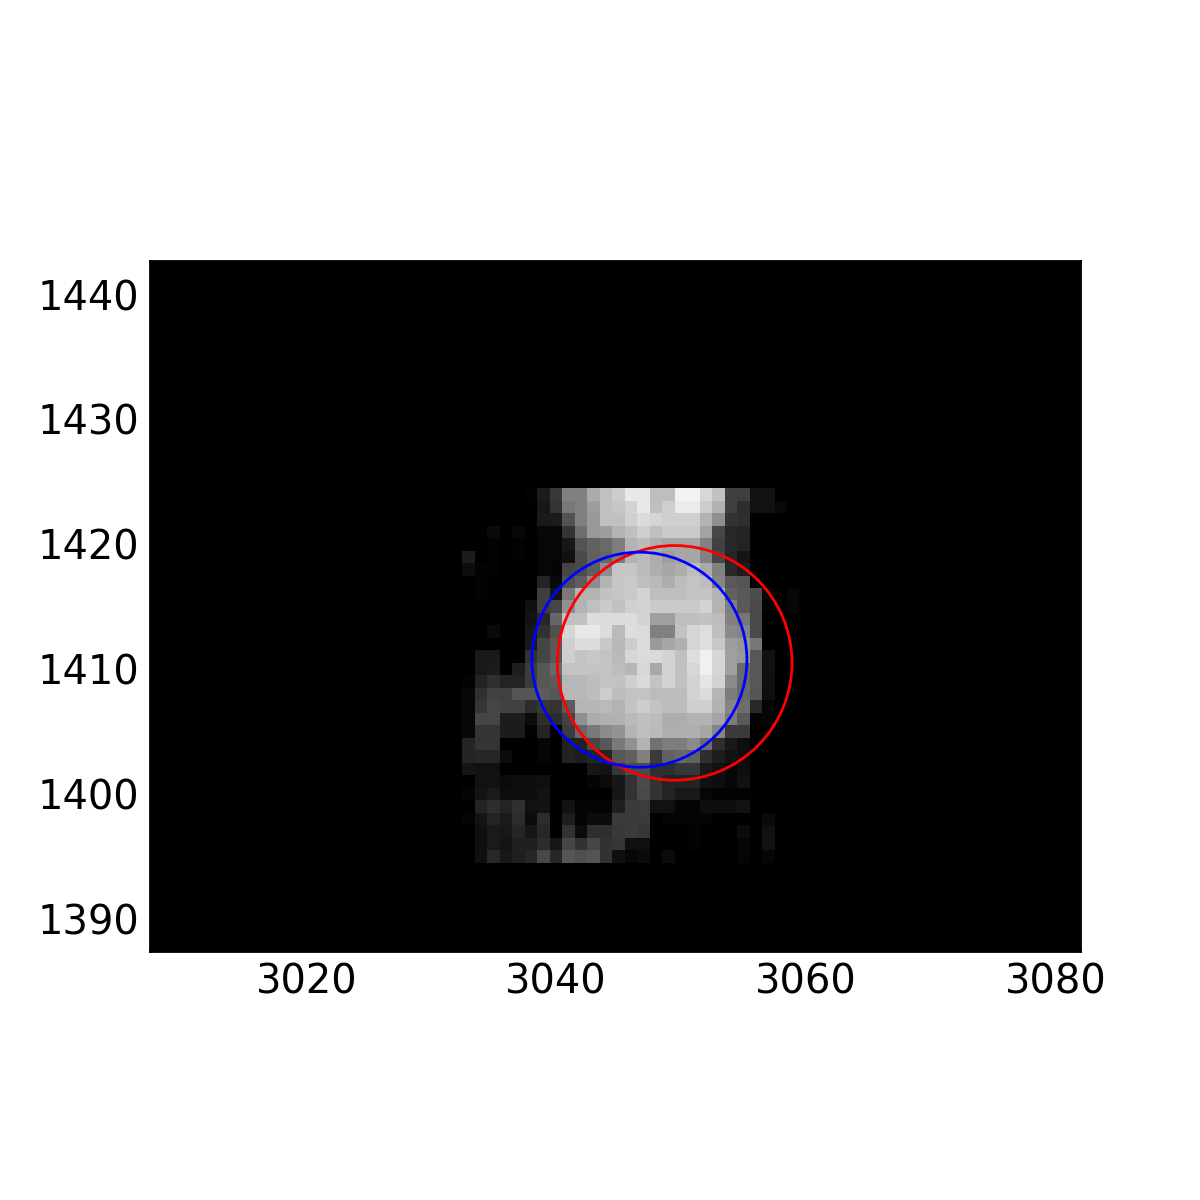

In [35]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')

im = ax.imshow(imag_new2, interpolation='nearest', cmap='gray', vmin=0, vmax=300, origin='lower')

for p in dot_pos2:
    c = plt.Circle((p[0], p[1]), p[2], color='red', fill=False)
    ax.add_artist(c)
for i,p in enumerate(dot_pos_new2):
    #if inlier[i]==1:
    c = plt.Circle((p[0], p[1]), p[2], color='blue', fill=False)
    ax.add_artist(c)

plt.show()

### write to file

In [36]:
dot_id = np.arange(len(dot_pos2))
dat = [[i, p1[0], p1[1], p1[2], p2[0], p2[1], p2[2]] for i, p1, p2 in zip(dot_id, dot_pos2, dot_pos_new2)]

In [37]:
filename = 'tmp.csv'
np.savetxt(filename, dat, delimiter=',', header='id,x_meas,y_meas,r_meas,x_tran,y_tran,r_tran', comments='')

In [38]:
df = pd.read_csv(filename)

<IPython.core.display.Javascript object>


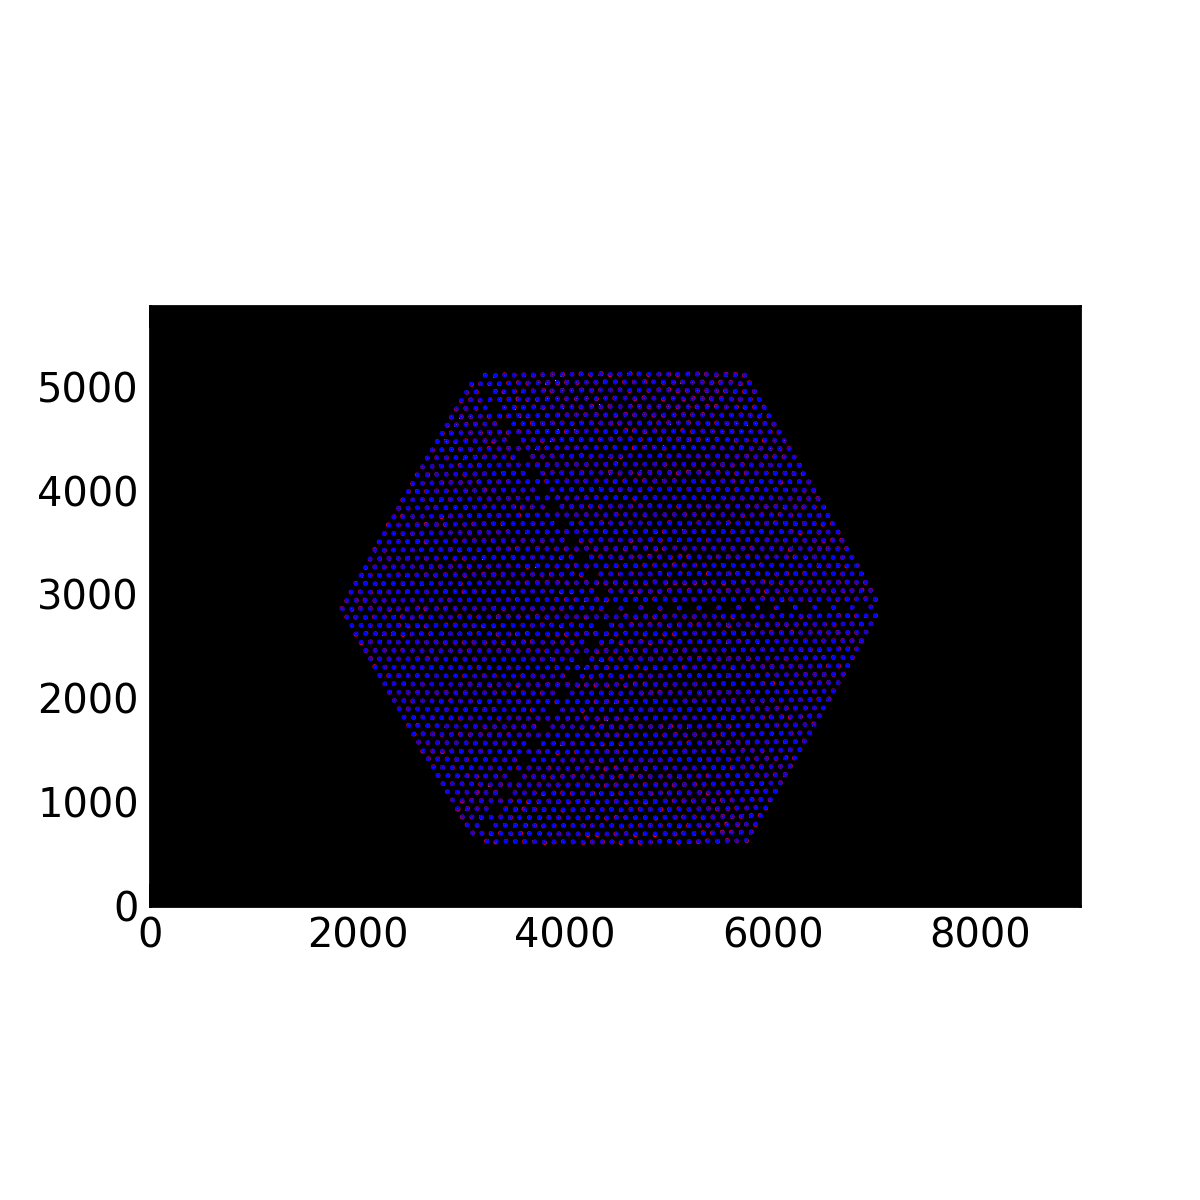

In [40]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')

im = ax.imshow(data, interpolation='nearest', cmap='gray', vmin=38000, vmax=40000, origin='lower')

for x,y,r in zip(df['x_meas'], df['y_meas'], df['r_meas']):
    c1 = plt.Circle((x,y), r, color='red', fill=False)
    ax.add_artist(c1)
for x,y,r in zip(df['x_tran'], df['y_tran'], df['r_tran']):
    c2 = plt.Circle((x,y), r, color='blue', fill=False)
    ax.add_artist(c2)

plt.show()

## rotator angle = 0 deg., EL = 60 deg.

### designed dots infomation

In [41]:
filename = os.path.join(repo_dir, 'data/pfi/dot',
                        'dot_design_asrd_20210422.txt')
fel = pd.read_csv(filename,
                  delim_whitespace=True,
                  header=None,
                  names=['id', 'x_mm', 'y_mm', 'x', 'y', 'bb', 'cc']
                 )
fel[:3]

,id,x_mm,y_mm,x,y,bb,cc
0,0,96.994843,0.0,5614.759176,2886.225955,5614.759277,2886.101562
1,1,103.923042,4.0,5695.685201,2932.765529,5695.393555,2932.880127
2,2,110.851250,8.0,5776.593112,2979.286068,5776.393066,2979.337891


### observed data

In [42]:
visit = 68836
filename = os.path.join(data_dir, 'PFSC%06d00.fits' % (visit))
with pyfits.open(filename) as f:
    data = f[1].data

### median filtering

In [43]:
data_med = nd.median_filter(data, size=3)

### transformation for initial guess (you need to do this carefully)

In [44]:
filename = './results/dot_measurements_subaru_20210926_el90_rot+00_v68840.csv'
dots_mcs_rough = pd.read_csv(filename)
rx = dots_mcs_rough['x_tran']
ry = dots_mcs_rough['y_tran']
dots_mcs_rough[:3]

,id,x_meas,y_meas,r_meas,x_tran,y_tran,r_tran
0,0.0,4490.5,2783.5,8.2,4489.355469,2787.317139,8.880127
1,1.0,4448.5,2704.5,9.4,4442.237305,2705.149170,8.878540
2,2.0,4398.5,2621.5,8.2,4395.125488,2623.004150,8.875732


In [45]:
rx = dots_mcs_rough['x_tran']
ry = dots_mcs_rough['y_tran']

### data region trimming

In [46]:
reg=20
thresh=3000

v_med =  np.median(data_med)
imag_new = np.zeros(data_med.shape)

for xd, yd in zip(rx, ry):
    x1 = int(xd - reg)
    x2 = int(xd + reg)
    y1 = int(yd - reg)
    y2 = int(yd + reg)
    v_med = np.median(data_med[y1-reg:y2+reg, x1-reg:x2+reg])
    imag_new[y1:y2, x1:x2] = data_med[y1:y2, x1:x2] - v_med
    
#plt.imshow(imag_new, origin='lower', cmap='gray', vmin=38000, vmax=40000)
plt.imshow(imag_new, origin='lower', cmap='gray', vmin=0, vmax=300)

### measure dot positions

In [47]:
reg=20

bad_idx = []
dot_pos = []
for i in range(len(rx)):
    #data_sub=imag_new_flt[int(ry[i]-reg):int(ry[i]+reg),int(rx[i]-reg):int(rx[i]+reg)]
    data_sub=imag_new[int(ry[i]-reg):int(ry[i]+reg),int(rx[i]-reg):int(rx[i]+reg)]
    imag_sub=deepcopy(data_sub)
    imag_sub[imag_sub<=0]=0.0
    imag_sub = 255 * imag_sub / imag_sub.max()

    circles = cv2.HoughCircles(imag_sub.astype('uint8'), cv2.HOUGH_GRADIENT, 1, 50,
                               param1=100,param2=5,minRadius=7,maxRadius=10)

    if circles is not None:
        dot_x = int(rx[i]-reg)+circles[0,0,0]
        dot_y = int(ry[i]-reg)+circles[0,0,1]
        dot_r = circles[0,0,2]
        dot_pos.append((dot_x, dot_y, dot_r))
    else:
        bad_idx.append(i)
        dot_pos.append((np.nan, np.nan, np.nan))
        print(f' dota id {i} at {rx[i]} {ry[i]} detection failed')
        
dot_pos = np.array(dot_pos)

<IPython.core.display.Javascript object>


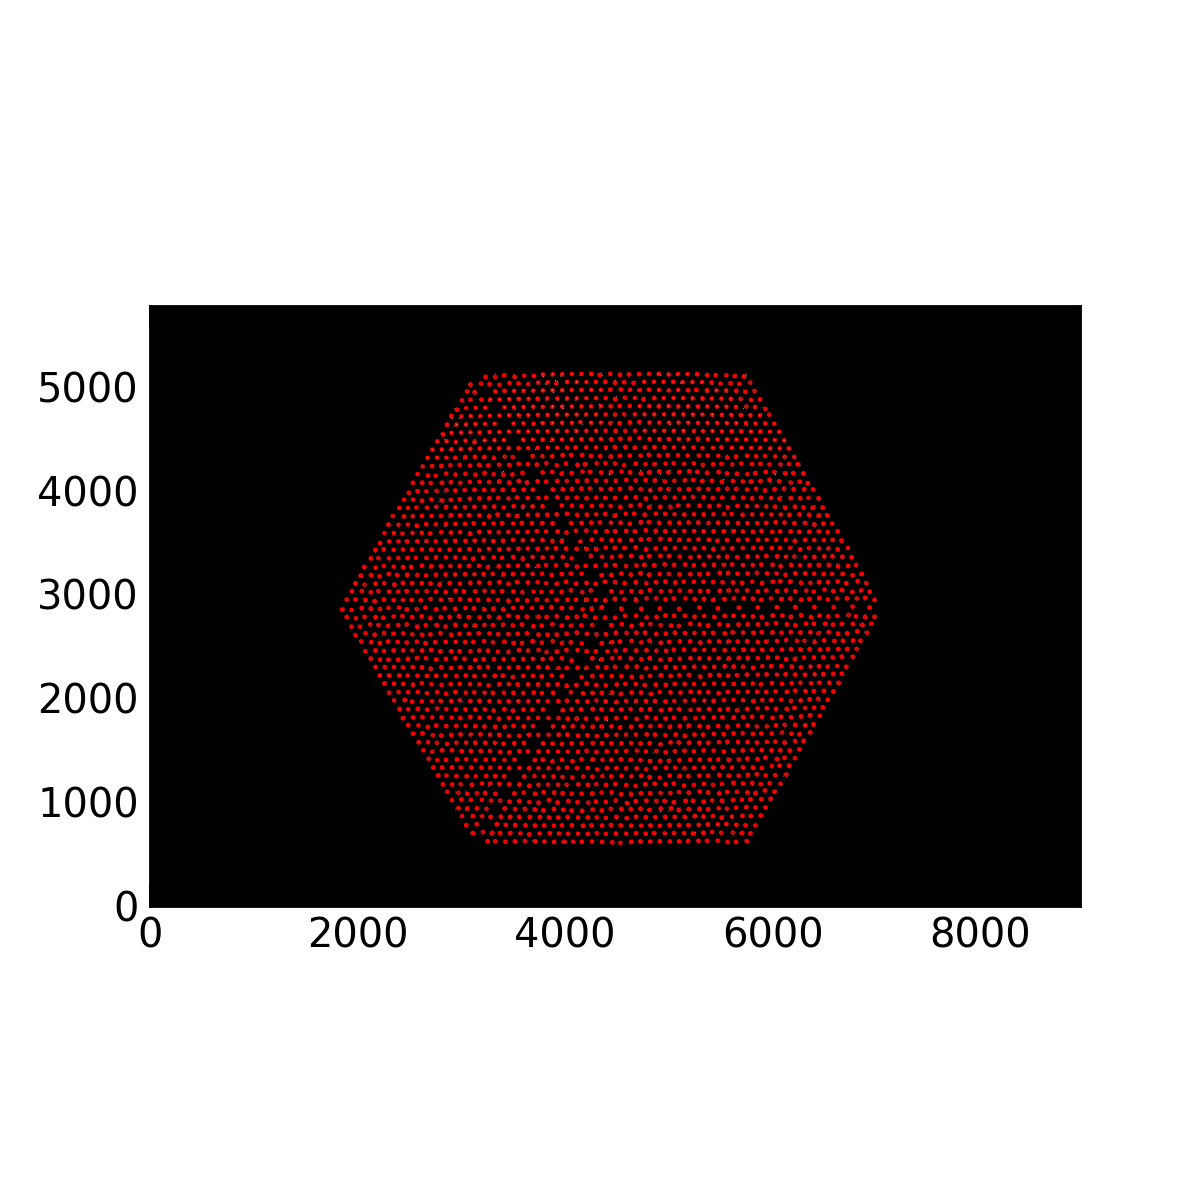

In [48]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')
im = ax.imshow(imag_new, interpolation='nearest', cmap='gray', vmin=0, vmax=300, origin='lower')
#imag_new_rev = 255 * imag_new / imag_new.max()
#im = ax.imshow(imag_new_rev.astype('uint8'), interpolation='nearest', cmap='gray', vmin=0, vmax=300, origin='lower')

for p in dot_pos:
    c = plt.Circle((p[0], p[1]), p[2], color='red', fill=False)
    ax.add_artist(c)
    
plt.show()

### get transformation coefficients (including distortion)

In [49]:
pts0=np.zeros((1,len(fel),3))
pts0[0,:,0]=fel['x_mm']
pts0[0,:,1]=fel['y_mm']
pts0[0,:,2]=[0 for x in fel['x_mm']]
pts1=np.zeros((1,len(fel),3))
pts2=np.zeros((1,len(fel),2))
pts1[0,:,0]=fel['x_mm']
pts1[0,:,1]=fel['y_mm']
pts1[0,:,2]=[0 for x in fel['x_mm']]
pts2[0,:,0]=dot_pos[:,0]
pts2[0,:,1]=dot_pos[:,1]

pts1 = np.float32(pts1)
pts2 = np.float32(pts2)

In [50]:
for i in np.sort(bad_idx)[::-1]:
    pts1 = np.delete(pts1, i, 1)
    pts2 = np.delete(pts2, i, 1)    

In [51]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(pts1, pts2, data.shape[::-1], None, None)

In [52]:
for i in range(len(pts0)):
    imgpoints2, _ = cv2.projectPoints(pts0[i].astype(np.float32),rvecs[i], tvecs[i], mtx, dist)

In [53]:
dot_pos_new = np.float32([[x,y,r] for x,y,r in zip(imgpoints2[:,0,0], imgpoints2[:,0,1], dot_pos[:,2])])

<IPython.core.display.Javascript object>


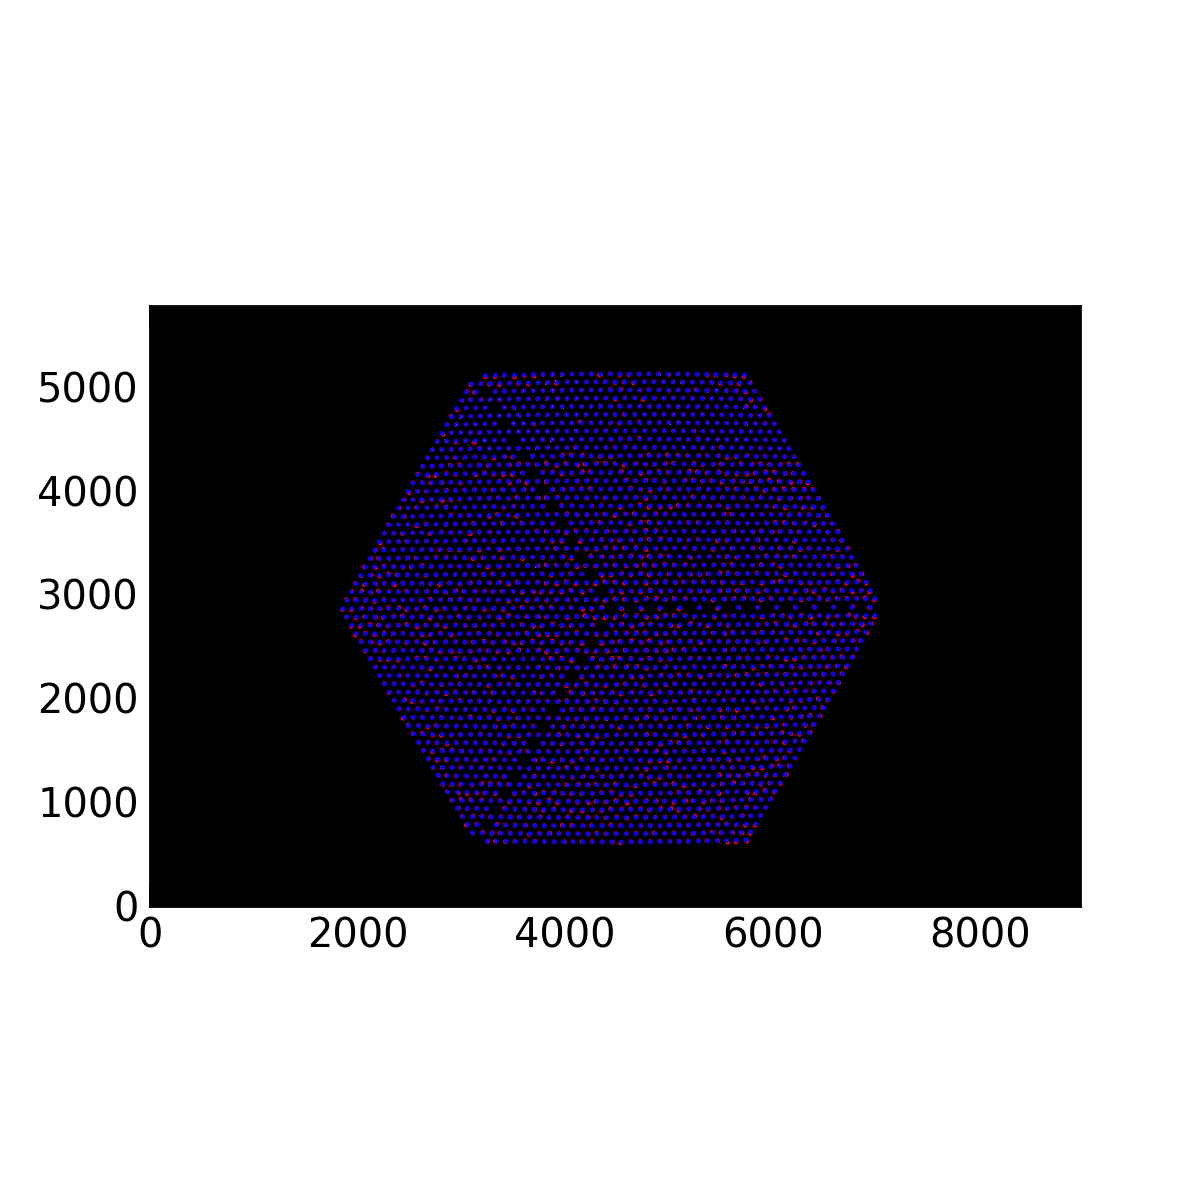

In [54]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')

im = ax.imshow(imag_new, interpolation='nearest', cmap='gray', vmin=0, vmax=300, origin='lower')

for p in dot_pos:
    c = plt.Circle((p[0], p[1]), p[2], color='red', fill=False)
    ax.add_artist(c)
for p in dot_pos_new:
    c = plt.Circle((p[0], p[1]), p[2], color='blue', fill=False)
    ax.add_artist(c)
    
plt.show()

### data region triming (2nd pass)

In [55]:
rx2 = dot_pos_new[:,0]
ry2 = dot_pos_new[:,1]

In [56]:
dot_pos_new

array([[4489.133 , 2788.0962,    8.2   ],
       [4441.9814, 2705.8335,    9.4   ],
       [4394.8384, 2623.5984,    9.3   ],
       ...,
       [3365.502 , 4722.5254,    8.2   ],
       [3275.6858, 4877.073 ,    8.2   ],
       [3186.8088, 5029.992 ,    8.2   ]], dtype=float32)

<IPython.core.display.Javascript object>


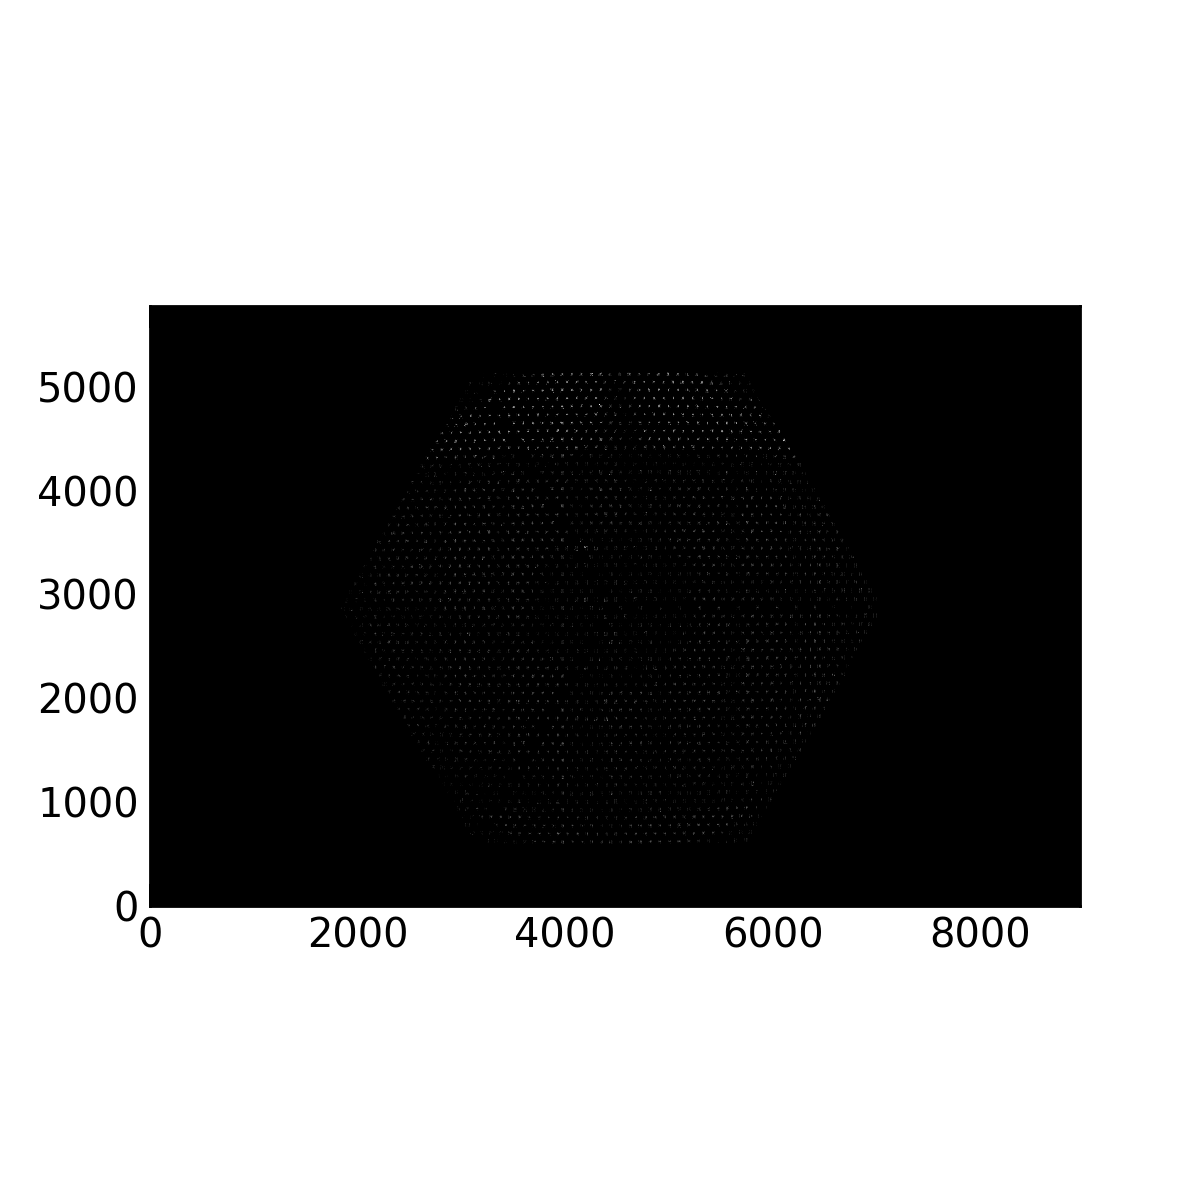

In [57]:
reg=20
thresh=3000

v_med =  np.median(data_med)
imag_new2 = np.zeros(data_med.shape)

for xd, yd in zip(rx2, ry2):
    x1 = int(xd - reg)
    x2 = int(xd + reg)
    y1 = int(yd - reg)
    y2 = int(yd + reg)
    v_med = np.median(data_med[y1-reg:y2+reg, x1-reg:x2+reg])
    imag_new2[y1:y2, x1:x2] = data_med[y1:y2, x1:x2] - v_med
    

fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')

im = ax.imshow(imag_new2, interpolation='nearest', cmap='gray', vmin=0, vmax=500, origin='lower')

plt.show()

### measure dot positions (2nd pass)

In [58]:
reg=20

imag_new2_disp = deepcopy(imag_new2)

bad_idx = []
dot_pos2 = []
for i in range(len(rx2)):
    data_sub=imag_new2[int(ry2[i]-reg):int(ry2[i]+reg),int(rx2[i]-reg):int(rx2[i]+reg)]
    imag_sub=deepcopy(data_sub)
    imag_sub = 255 * imag_sub / imag_sub.max()

    imag_new2_disp[int(ry2[i]-reg):int(ry2[i]+reg),int(rx2[i]-reg):int(rx2[i]+reg)] = imag_sub
    
    circles = cv2.HoughCircles(imag_sub.astype('uint8'), cv2.HOUGH_GRADIENT, 1, 50,
                               param1=100,param2=5,minRadius=7,maxRadius=10)

    if circles is not None:
        dot_x = int(rx2[i]-reg) + circles[0,0,0]
        dot_y = int(ry2[i]-reg) + circles[0,0,1]
        dot_r = circles[0,0,2]
        dot_pos2.append((dot_x, dot_y, dot_r))
    else:
        bad_idx.append(i)
        dot_pos2.append((np.nan, np.nan, np.nan))
        print(f' dota id {i} at {rx[i]} {ry[i]} detection failed')

dot_pos2 = np.array(dot_pos2)

<IPython.core.display.Javascript object>


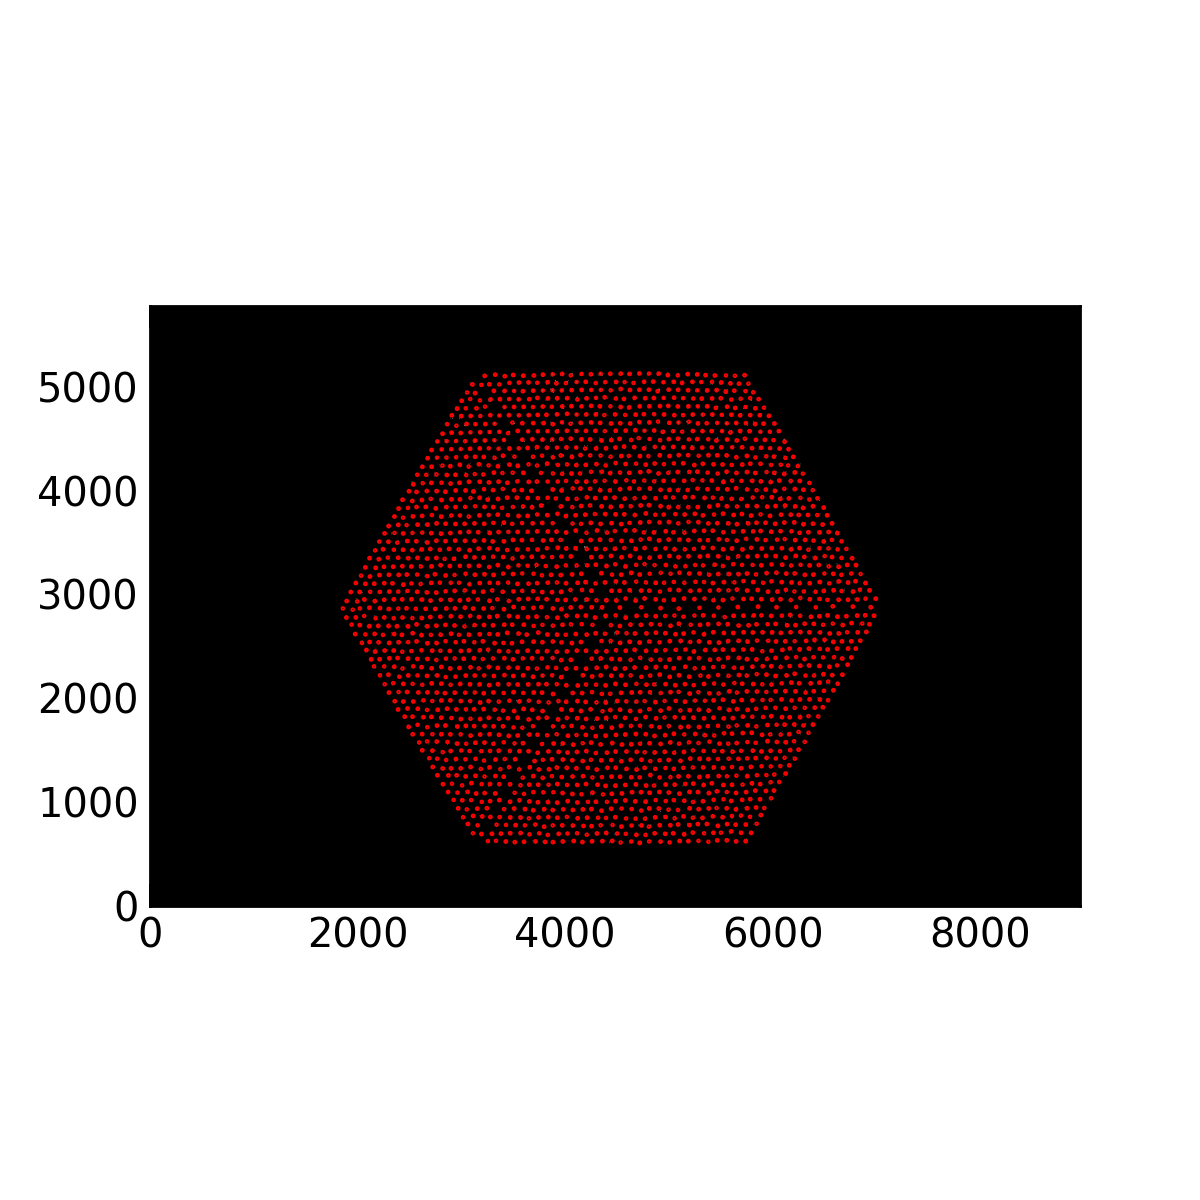

In [59]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')

im = ax.imshow(imag_new2, interpolation='nearest', cmap='gray', vmin=0, vmax=500, origin='lower')

for p in dot_pos2:
    c = plt.Circle((p[0], p[1]), p[2], color='red', fill=False)
    ax.add_artist(c)
    
plt.show()

### get transformation coefficients (2nd pass)

In [60]:
pts0=np.zeros((1,len(fel),3))
pts0[0,:,0]=fel['x_mm']
pts0[0,:,1]=fel['y_mm']
pts0[0,:,2]=[0 for x in fel['x_mm']]
pts1=np.zeros((1,len(fel),3))
pts2=np.zeros((1,len(fel),2))
pts1[0,:,0]=fel['x_mm']
pts1[0,:,1]=fel['y_mm']
pts1[0,:,2]=[0 for x in fel['x_mm']]
pts2[0,:,0]=dot_pos2[:,0]
pts2[0,:,1]=dot_pos2[:,1]

pts1 = np.float32(pts1)
pts2 = np.float32(pts2)

In [61]:
for i in bad_idx:
    pts1 = np.delete(pts1, i, 1)
    pts2 = np.delete(pts2, i, 1)    

In [62]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(pts1, pts2, data.shape[::-1], None, None)

In [63]:
## calculate dot position ##
for i in range(len(pts0)):
    imgpoints2, _ = cv2.projectPoints(pts0[i].astype(np.float32),rvecs[i], tvecs[i], mtx, dist)

In [64]:
## calculate dot radius ##
pts0d = deepcopy(pts0)
pts0d[0,:,0] = pts0d[0,:,0] + 1.5

for i in range(len(pts0)):
    tmp1, _ = cv2.projectPoints(pts0[i].astype(np.float32),rvecs[i], tvecs[i], mtx, dist)
for i in range(len(pts0d)):
    tmp2, _ = cv2.projectPoints(pts0d[i].astype(np.float32),rvecs[i], tvecs[i], mtx, dist)

dot_rad = (tmp1[:,0,1] - tmp2[:,0,1]) / 2.0

In [65]:
dot_rad

array([8.887817, 8.885742, 8.88208 , ..., 8.510254, 8.441162, 8.366699],
      dtype=float32)

In [66]:
dot_pos_new2 = np.float32([[x,y,r] for x,y,r in zip(imgpoints2[:,0,0], imgpoints2[:,0,1], dot_rad[:])])

<IPython.core.display.Javascript object>


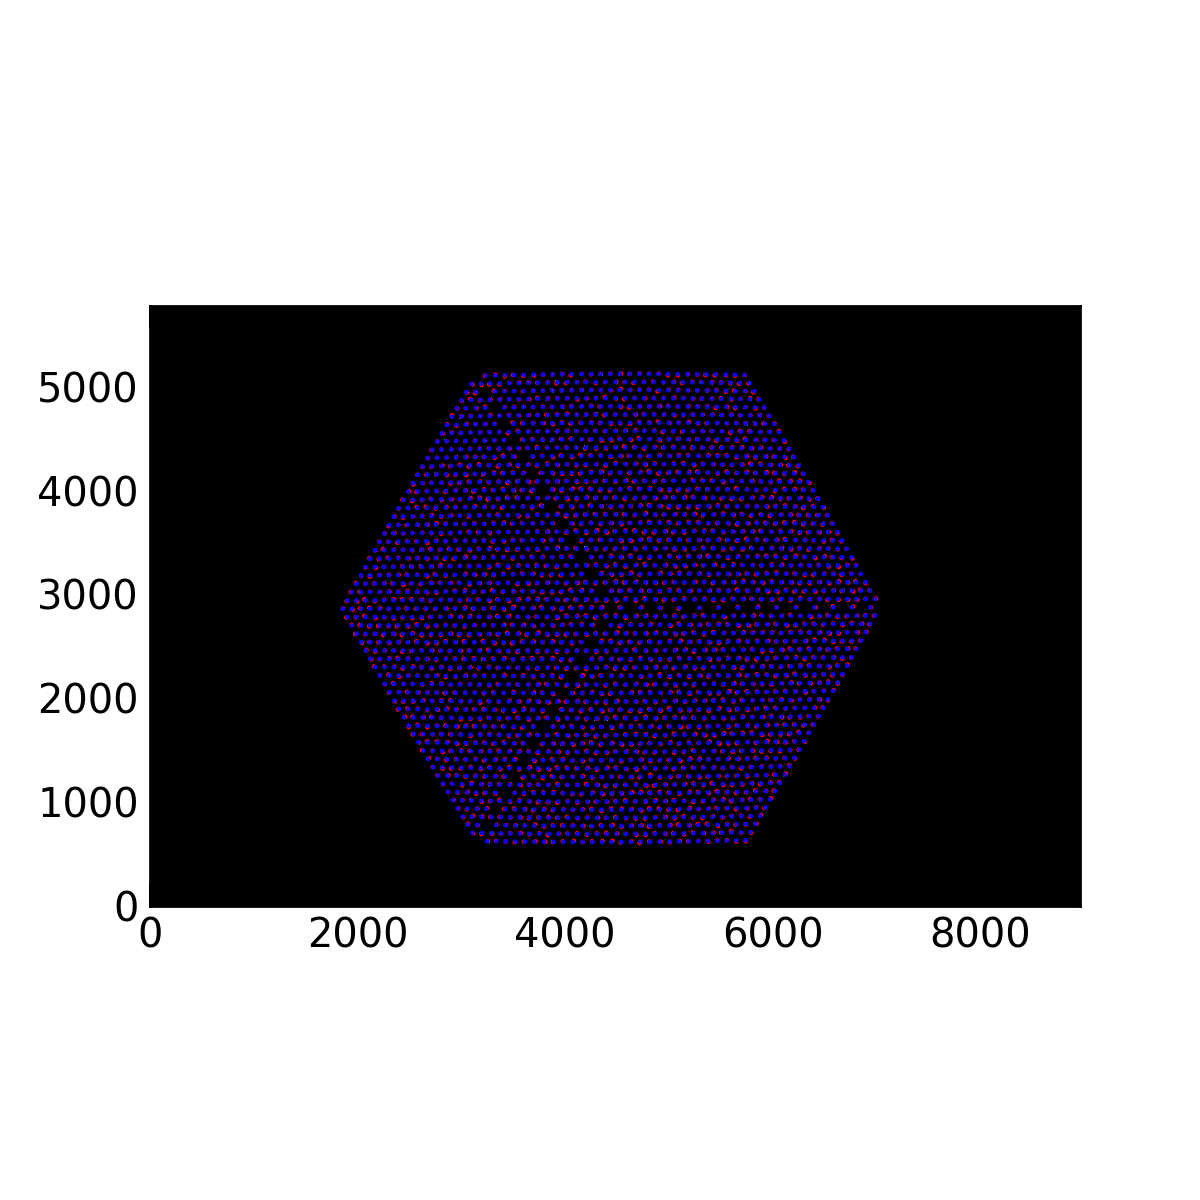

In [67]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')

im = ax.imshow(imag_new2, interpolation='nearest', cmap='gray', vmin=0, vmax=300, origin='lower')

for p in dot_pos2:
    c = plt.Circle((p[0], p[1]), p[2], color='red', fill=False)
    ax.add_artist(c)
for i,p in enumerate(dot_pos_new2):
    #if inlier[i]==1:
    c = plt.Circle((p[0], p[1]), p[2], color='blue', fill=False)
    ax.add_artist(c)

plt.show()

### write to file

In [68]:
dot_id = np.arange(len(dot_pos2))
dat = [[i, p1[0], p1[1], p1[2], p2[0], p2[1], p2[2]] for i, p1, p2 in zip(dot_id, dot_pos2, dot_pos_new2)]

In [69]:
filename = 'tmp.csv'
np.savetxt(filename, dat, delimiter=',', header='id,x_meas,y_meas,r_meas,x_tran,y_tran,r_tran', comments='')

In [70]:
df = pd.read_csv(filename)

<IPython.core.display.Javascript object>


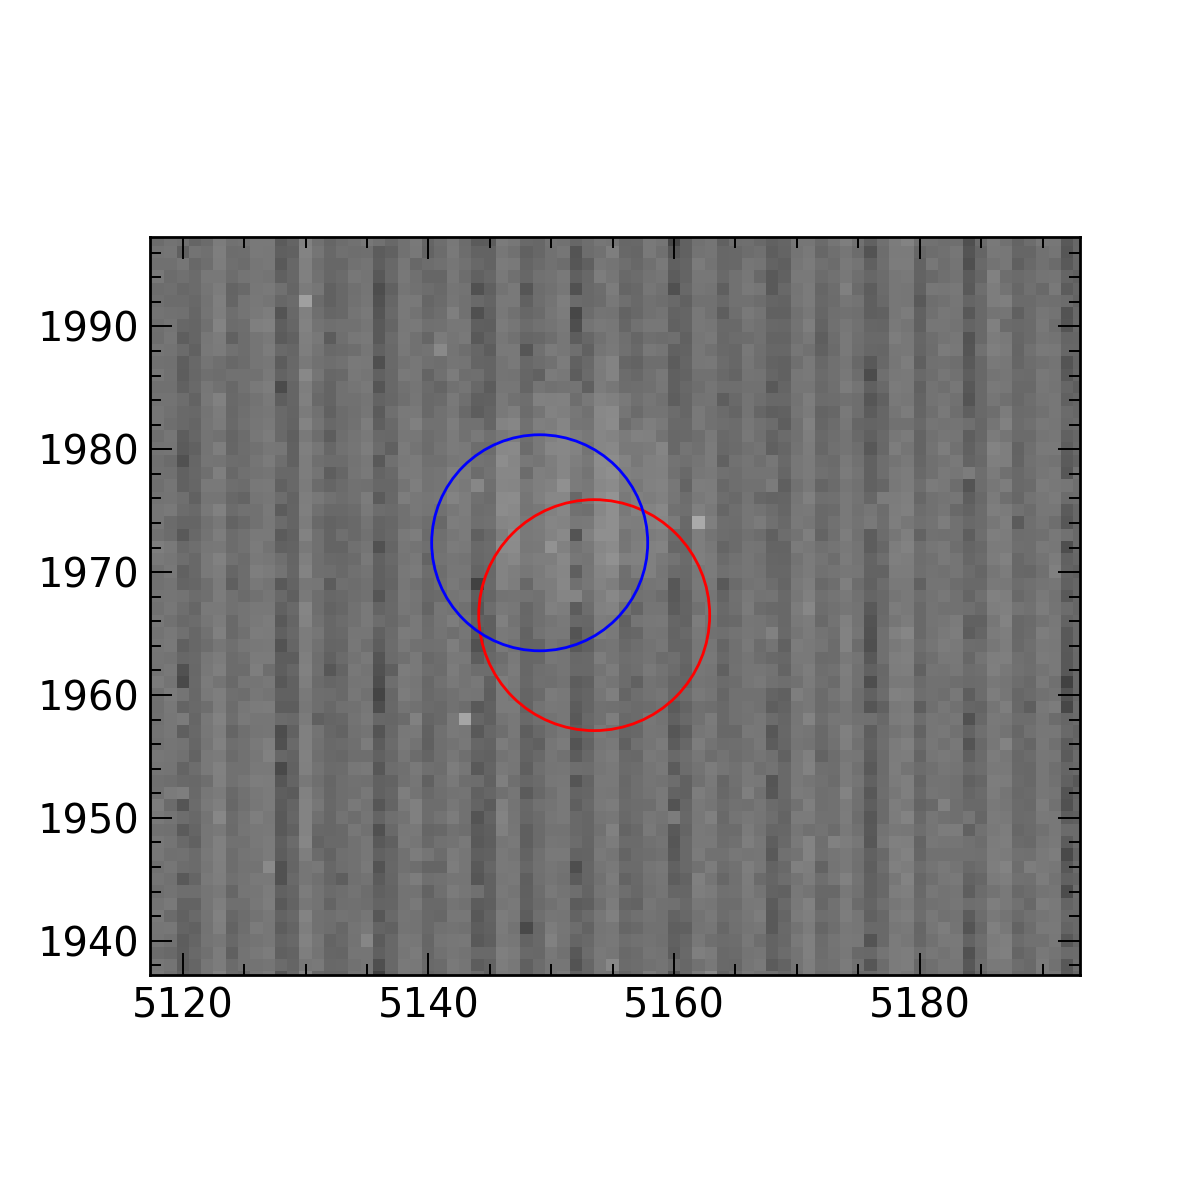

In [72]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')

im = ax.imshow(data, interpolation='nearest', cmap='gray', vmin=38000, vmax=40000, origin='lower')

for x,y,r in zip(df['x_meas'], df['y_meas'], df['r_meas']):
    c1 = plt.Circle((x,y), r, color='red', fill=False)
    ax.add_artist(c1)
for x,y,r in zip(df['x_tran'], df['y_tran'], df['r_tran']):
    c2 = plt.Circle((x,y), r, color='blue', fill=False)
    ax.add_artist(c2)

plt.show()